In [9]:
import os
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [10]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [11]:
print(train_data.shape)
print(test_data.shape)
print(max(train_targets), min(train_targets))

(404, 13)
(102, 13)
50.0 5.0


In [12]:
mean = train_data.mean(axis=0)
print(mean)
train_data -= mean
std = train_data.std(axis=0)
print(std)
train_data /= std

test_data -= mean
test_data /= std

[3.74511057e+00 1.14801980e+01 1.11044307e+01 6.18811881e-02
 5.57355941e-01 6.26708168e+00 6.90106436e+01 3.74027079e+00
 9.44059406e+00 4.05898515e+02 1.84759901e+01 3.54783168e+02
 1.27408168e+01]
[9.22929073e+00 2.37382770e+01 6.80287253e+00 2.40939633e-01
 1.17147847e-01 7.08908627e-01 2.79060634e+01 2.02770050e+00
 8.68758849e+00 1.66168506e+02 2.19765689e+00 9.39946015e+01
 7.24556085e+00]


In [13]:
from keras import models
from keras import layers

In [14]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [15]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epoachs = 100
all_scores = []

# k-fold validation
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epoachs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [16]:
print(all_scores)
print(np.mean(all_scores))

[2.1218072305811515, 2.26759399990044, 2.9549240499439806, 2.4115195894005277]
2.4389612174565247


In [17]:
num_epochs = 500
all_mae_histories = []

# k-fold validation
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [18]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

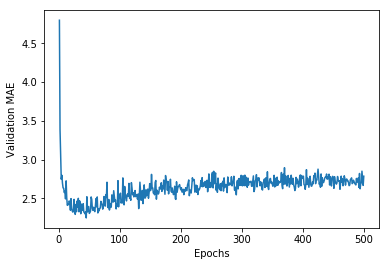

In [20]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [21]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [22]:
smooth_mae_history = smooth_curve(average_mae_history[10:])
print(min(smooth_mae_history), max(smooth_mae_history))

2.3578221884521855 2.7565117583639256


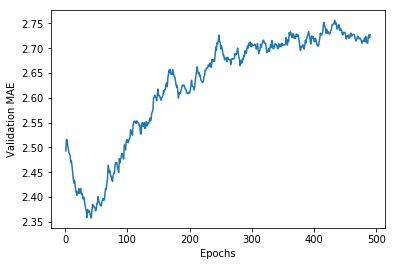

In [23]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [24]:
model = build_model()
model.fit(train_data, train_targets,
epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


In [25]:
print(test_mae_score)

2.672603149040073
